### Christopher Miller
### Homework 3 - EECS495 - Chapter 9 Assignments
### Northwestern University - Fall 2018

Problems 9.3 and 9.6

#### Problem 9.3
Produce two contour plots of the Least Squares cost function over the student debt dataset: one for the dataset and one for the standard normalized edition. Compare the overall topology of each plot and describe which will be easier to optimize over using Gradient descent. 

Minimize the Least Squares cosat using the normalized version of gradient descent and recreate Figure 9.3.



In [2]:
#Problem 9.3 - read in the data 
# libraries
from autograd import numpy as np

# import the dataset
csvname = 'datasets/student_debt_data.csv'
data = np.loadtxt(csvname,delimiter=',')

# cut into input/output data
x = data[0:1,:]
y = data[1:,:]

In [3]:
#Import the data and make sure everything works
import matplotlib.pyplot as plt
figure = plt.figure()
plt.scatter(x,y)
plt.show()

<Figure size 640x480 with 1 Axes>

<function matplotlib.pyplot.show(*args, **kw)>

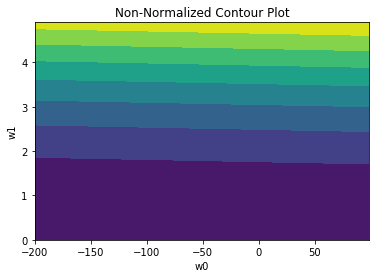

In [4]:
#weight generation for contours (non-norm-ed)
w0 = np.arange(-200,100,1)
w1 = np.arange(0,5,0.1)

#Make the mesh grid
pltX, pltY = np.meshgrid(w0,w1)
#Now, we run the cost function 
d1,d2 = np.shape(pltX)

#Cost one
Z1 = np.zeros((d1,d2))

#Compute the costs for the contour plot
for i in range(0,d1):
    for j in range(0,d2):
        Z1[i][j] = np.sum((y - (pltX[i][j] + pltY[i][j]*x))**2)

#Show the contour plot
plt.contourf(pltX,pltY,Z1)
plt.title('Non-Normalized Contour Plot')
plt.xlabel('w0')
plt.ylabel('w1')
plt.show

[ 0.65275     0.23199543]


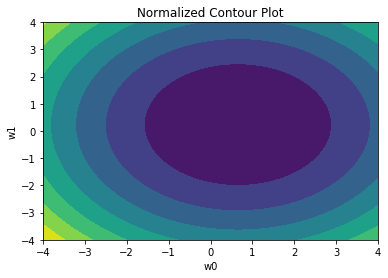

In [5]:
#Normalize the input points
#mus
mux = np.mean(x)
#st-ds
stx = np.std(x)
#Normalize each
xn = (x-mux)/stx

#Minimize the function (using Q5.1 from HW2
#Assemble the matricies 
v1 = xn[0]**0
v2 = xn[0]**1
V = np.transpose(np.vstack((v1,v2)))

#Get Linear regression parameters
A = np.dot(np.transpose(V),V)
b = np.dot(np.transpose(V),np.transpose(y))

#solve the linear system
params = np.dot(np.linalg.inv(A),b).flatten()
print(params)

#Based on the params, generate w1, w2
w0 = np.arange(-4,4,0.01)
w1 = np.arange(-4,4,0.01)

#Make the mesh grid
pltX, pltY = np.meshgrid(w0,w1)

#Now, we run the cost function 
d1,d2 = np.shape(pltX)

#Cost two 
Z2 = np.zeros((d1,d2))

#Compute the costs for the contour plot
for i in range(0,d1):
    for j in range(0,d2):
        Z2[i][j] = np.sum((y - (pltX[i][j] + pltY[i][j]*xn))**2)      
        
#Show the contour plot
plt.contourf(pltX,pltY,Z2)
plt.title('Normalized Contour Plot')
plt.xlabel('w0')
plt.ylabel('w1')
plt.show()

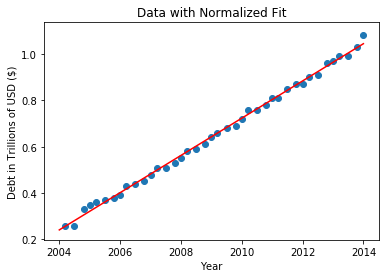

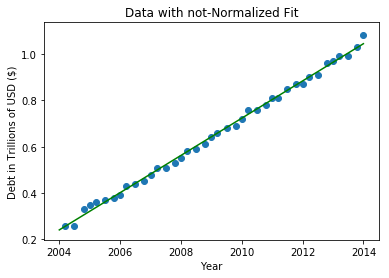

The average error between the normalized and non-normalized least-squares regressions is:  -1.97535422363e-12


In [6]:
#Considering we already minimized the cost function... 
#here's a plot with the real data and the fitted line

#Mock Years
x_line = np.arange(2004,2015,1)

#Compute fit_line_data with the data normalized to fit..
fit_data = params[1]*((x_line-mux)/stx)+params[0]

#Now we compute the fit without normalization
#Assemble the matricies 
v1 = x[0]**0
v2 = x[0]**1
V = np.transpose(np.vstack((v1,v2)))

#Get Linear regression parameters
A = np.dot(np.transpose(V),V)
b = np.dot(np.transpose(V),np.transpose(y))

#solve the linear system
lame_params = np.dot(np.linalg.inv(A),b).flatten()
lame_fit = lame_params[1]*x_line+lame_params[0]

#Plot the normalized fit line
figure = plt.figure()
plt.scatter(x,y)
plt.plot(x_line,fit_data,c = 'r')
plt.title('Data with Normalized Fit')
plt.xlabel('Year')
plt.ylabel('Debt in Trillions of USD ($)')
plt.show()

#Plot the non-normalized fit line
figure = plt.figure()
plt.scatter(x,y)
plt.plot(x_line,lame_fit,c = 'g')
plt.title('Data with not-Normalized Fit')
plt.xlabel('Year')
plt.ylabel('Debt in Trillions of USD ($)')
plt.show()

#Calculate the error between the two fits
fit_diffy = fit_data-lame_fit

#Compute the mean difference in fit points
print("The average error between the normalized and non-normalized least-squares regressions is: ",
      np.mean(fit_diffy))

When running gradient descent, it would be *far* easier to minimize the least squares cost function for the normalized data (as shown in the "non-normalized contour plot"). The normalized data forms smooth, regular contours as displayed in the "Normalized Contour Plot."

However, fitting the least squares problem using Vandermode Matricies and a few tricks of linear algebra yields a similar fit line for both the normalized and un-normalized data, as shown in the "Data with..." polts above. The error between the two fit lines is on the order of $10^{-12}$ which, to many is consider negligible. For more complex problems, normalization is very likely necessary. For this dataset it's clearly an exercise that, when using the tricks of linear algebra, does not yield many fruitful results.

#### Problem 9.6

Compute a run of 10 gradient descent steps using the multi-class Softmax cost over 50,000 random digits from the MNIST dataset three ways: 

- Using the regular dataset
- Using the normalized dataset 
- Using the PCA-sphered dataset

For each, use the largest value of $\gamma$ possible in $\alpha = 10^{-\gamma}$ that produces decent results.

Create both a cost function history plot and a misclassification history plot comparing all three 

In [7]:
#Load in the data from the sample code 

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

# strip off input / output pairs
x = mnist.data.T
y = mnist.target[np.newaxis,:]

In [8]:
print("input shape = " , x.shape)
print("output shape = ", y.shape)

input shape =  (784, 70000)
output shape =  (1, 70000)


In [9]:
# sample indices
num_sample = 50000
inds = np.random.permutation(y.shape[1])[:num_sample]
x_sample = x[:,inds]
y_sample = y[:,inds]

In [35]:
# compute C linear combinations of input point, one per classifier
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# multiclass softmaax cost
def multiclass_softmax(w,x,y):        
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute softmax across data points
    a = np.log(np.sum(np.exp(all_evals),axis = 0)) 
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))]
    cost = np.sum(a - b)
    
    # return average
    return cost/float(np.size(y))

#g = multiclass_softmax

In [76]:
#All sample code imported, now we want to minimize gradient descent. Importing the gradient descent from HW2's
#Solutions
from autograd.misc.flatten import flatten_func
from autograd import grad as gradient 
from timeit import default_timer as timer
from autograd import value_and_grad

# gradient descent - imported from my submission for HW2 
def gradient_descent(g,w,x,y,alpha_c,maxits):
    #storage 
    w_hx = []
    cost_hx = []
    #Alpha
    alpha = alpha_c
    #flatten input funct and generate gradient 
    g_flat,unflatten, w1 = flatten_func(g,w)
    
    #Define the gradient function
    dg = gradient(g_flat)
    
    #define h vector that's of the same shape as w vector
    m = np.zeros((w.shape))
    #Again, use 1 to max_its+1. Easier.
    for k in range(1,maxits+1):
            
        #Evaluate the gradient and store
        grad_eval = dg(w,x,y)
        cost_eval = g(w,x,y)
        w_hx.append(w)
        cost_hx.append(cost_eval)

        #take the gradient step (note the sign change here!)
        w = w - alpha*grad_eval
    
    #Append final values
    w_hx.append(w)
    cost_hx.append(g(w,x,y))
    
    return w_hx, cost_hx

In [55]:
# ---- HERE'S MY WORK ---- 

#Regular Data
x = x_sample

#Normalized Data
muu = np.mean(x_sample)
stdd = np.std(x_sample)
x_norm = (x_sample-muu)/stdd

#PCA-Sphered data 
x_PCA_temp = x_sample - muu
#Size
P = float(x_PCA_temp.shape[1])
#Correlation matrix + some numerical stability 
Cov = (1/P)*np.dot(x_PCA_temp,np.transpose(x_PCA_temp)) + 10**(-7)*np.eye(x_PCA_temp.shape[0])
#Eigs
d,V = np.linalg.eigh(Cov)
#Compute the PCA Sphere-d data (Rotate)
x_PCAd = np.dot(np.transpose(V),x_PCA_temp)
#Divide off the STD
x_PCAd = x_PCAd/stdd

In [85]:
# Now, run the gradient descents - from the HW2 solution (mostly)
#Params
g = multiclass_softmax
max_its = 10
N = x_sample.shape[0]
C = len(np.unique(y_sample))
w = 0.1*np.random.randn(N+1,C)

In [92]:
#The Descents:

# make first run
alpha = 10**(-100)
weight_history_1,chx1 = gradient_descent(g,w,x,y_sample,alpha,max_its)
print(chx1)


# make second run
alpha = 10**(-1)
weight_history_2,chx2 = gradient_descent(g,w,x_norm,y_sample,alpha,max_its)
print(chx2)


# make second run
alpha = 10**(-1)
weight_history_3,chx3 = gradient_descent(g,w,x_PCAd,y_sample,alpha,max_its)
print(chx3)

/home/chris/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/home/chris/anaconda3/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:73: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)


[inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[4.5535165952035364, 3.021945195990011, 2.1924537692659634, 1.7612980837053278, 1.4979210012449662, 1.3177896954786126, 1.1873614749209813, 1.0881139439842826, 1.0101977822474417, 0.9473123883784268, 0.89556473552070881]
[4.4838615939988635, 2.9527280156861053, 2.0729149388623482, 1.6717092880559015, 1.4062238035342747, 1.2418729203353727, 1.1166208890984779, 1.0266120229302265, 0.95564393821249527, 0.8998484938533754, 0.85436431487918496]


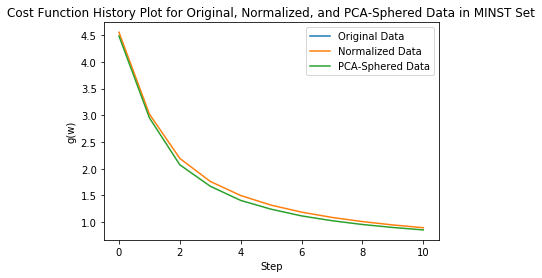

In [94]:
#Plot the cost function history
#Plot solutions
plt.plot(list(range(0,len(chx1),1)), chx1)
plt.plot(list(range(0,len(chx2),1)), chx2)
plt.plot(list(range(0,len(chx3),1)), chx3)
plt.xlabel('Step')
plt.ylabel('g(w)')
plt.legend(['Original Data', 'Normalized Data', 'PCA-Sphered Data'])
plt.title('Cost Function History Plot for Original, Normalized, and PCA-Sphered Data in MINST Set')
plt.show()